# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
# let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


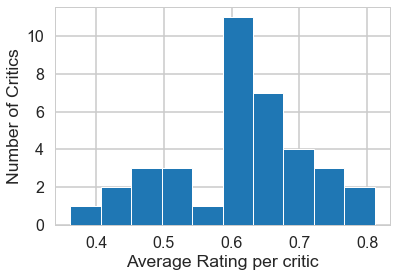

In [4]:
# copy the data
df = critics.copy()
# set 'fresh' column of df to 1 if fresh' or 0 if , 'rotten' or 'none'...
df['fresh'] = df.fresh == 'fresh'
# group it all by critic
grp = df.groupby('critic')
# count the movies the critic reviewed for all critics
counts = grp.critic.count()  # number of reviews by each critic
# get the average rating for each critic
means = grp.fresh.mean()     # average freshness for each critic

# we're only looking at the critics who reviewed more than 100 movies here...
means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [5]:
# get the average rating across all these critics
print('Average rating across critics with 100+ revivews: {:0.3f}'.format(means[counts > 100].mean()))

Average rating across critics with 100+ revivews: 0.612


<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

### Exercise Set I answer:

__The histogram shows information about the 37 critics who wrote more than 100 reviews. When I talk about critics, I mean this population.__

__The average rating of all these critics is 0.612. This says people who write a lot of movie reviews like the majority of movies. Said another way, these folks, as a group, like more movies than they dislike.__

__The distribution looks almost like a normal distribution, except that it's skewed to the right. The right half is swollen, which reflects the average rating.__

__It's interesting that most of the reviewers (31/37) liked at least half of the movies while no reviewers liked more than 80% of the movies.__

__One could make some inferences:__

* __Movie reviewers like movies.__
* __Movie reviewers who don't like movies don't review them.__
* __Not many reviewers are inclined to give poor reviews to most movies.__

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [7]:
# This function uses 2 columns from critics: quote and fresh
# uses CountVectorizer to produce a sparse matrix representation of the quote - those word-vectors become the X array
# uses 1 for fresh=='fresh', 0 for fresh!= anything else
def make_xy(critics, vectorizer=None):
    #Your code here 
    # this code provided
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y

# I might want to look at this...
# theVectorizor = CountVectorizer(stop_words='english')

X, y = make_xy(critics)

In [8]:
type(X), type(y)

(scipy.sparse.csc.csc_matrix, numpy.ndarray)

In [9]:
critics.shape

(15561, 8)

In [10]:
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [11]:
### 15.5k movie reviews; 22.4k different words
X.shape

(15561, 22417)

## Naive Bayes

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

### Exercise Set II answers:

#### I would characterize it as decent - 75+% on the test set isn't a bad result.  The training set is well fit, but the model doesn't generalize to the test set.   In other words, the model is overfit.

In [12]:
# your turn 

### the code
# import the classifier to instantiate
from sklearn.naive_bayes import MultinomialNB
# get train_test
from sklearn.model_selection import train_test_split
# make training and test sets 
x_train, x_test, y_train, y_test = train_test_split(X, y)
# make an instance and fit it to the test set
model = MultinomialNB().fit(x_train, y_train)
# score the model (accuracy score)
print('model accuracy on training set: {:.4f}'.format(model.score(x_train, y_train)))
print('model accuracy on test set: {:.4f}'.format(model.score(x_test, y_test)))

model accuracy on training set: 0.9219
model accuracy on test set: 0.7656


### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

### Exercise Set III answers:

##### Based on the reasoning above, min_df could be set to 1 or 2.  It's probably worth measuring (see below - code is modified to find best alpha, min_df and max_df).

##### Max_df plateaus around 100 documents.

In [13]:
# what we really want is to make a boolean matrix (true if not zero) and then sum that along the columns;
# then we have the document count for each word
word_use = X != 0

In [14]:
theDocFreqs = np.squeeze(np.asarray(np.sum(word_use, axis=0)))

In [15]:
# we have 22.4k different words.  Each element in array is the number of documents that each word is in.
theDocFreqs.shape

(22417,)

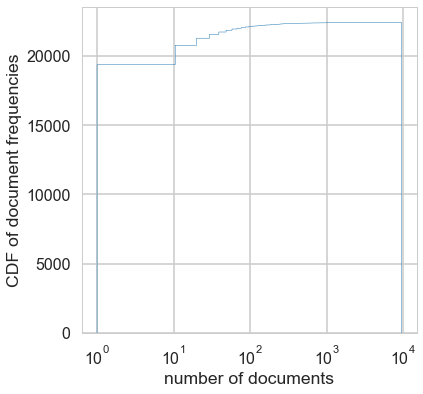

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(theDocFreqs, histtype='step', cumulative=True, bins=1000);
ax.set_xscale('log')
# plt.xlim(0, 1000)
# plt.yticks(np.arange(0, 1.05, 0.1))
ax.set_xlabel('number of documents')
ax.set_ylabel('CDF of document frequencies');

####  The parameter $\alpha$

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [17]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.  # accumulator for result
    nfold = 5    # 5 folds
    for train, test in KFold(nfold).split(X):      # split data into train/test groups
        clf.fit(X[train], y[train])                # fit the classifier, passed in as clf.
        result += scorefunc(clf, X[test], y[test]) # add score on held-out data to accumulator
    return result / nfold                          # return the average score          

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [18]:
# function parameters x and y are arrays; x is (num_rows, features); y is (num_rows)
# presumably clf is a fitted classifier
def log_likelihood(clf, x, y):
    # print('x shape: ', x.shape, 'y shape: ', y.shape)
    # prob is now an array of log probabilities, shape=(num_rows, num_classes)
    prob = clf.predict_log_proba(x)
    # print('prob shape: ', prob.shape)
    # what we do depends on what y is.  rotten is 1 if y == 0, or 0 if y == 1
    rotten = y == 0   # this is a boolean vector, 1 where the review is rotten
    fresh = ~rotten   # this is a boolean vector, 1 where the review is fresh
    # print('prob[rotten, 0].shape: ', prob[rotten, 0].shape)
    # print('prob[fresh, 1].shape: ', prob[fresh, 1].shape) 

    # we're adding up columns here           and here, then adding the sums together.
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [19]:
from sklearn.model_selection import train_test_split
# make a split of the appropriate size
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
# make a mask array 
mask = np.zeros(critics.shape[0], dtype=np.bool)
# set the mask to true for rows in the test set
mask[itest] = True

C:\Users\saus\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

### Exercise Set IV answers:

* __We're getting the log probabilty back for all the predictions.  Then we take these probabilities for each label and add them together (which gives the log of the product of the individual probabilities).  The logs of product for each label are then summed.  The higher this result is, the more likely we are to predict correctly; that's what's being optimized.__


* __Alpha is a smoothing parameter.  What is does in practice (in addition to providing non-zero value for multiplication/log) is to reduce the variance of the data.  That means if it's too high, it will mask the predictive properties in the data (because the data will be too smooth).  That will result in an underfit model.__


* __Note: Modified the code to search for best combination of alpha, min and max document frequency.__

In [20]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs = [1,  4,  16,  64]
max_dfs = [256, 1024, 2048]

# Find the best values for alpha, max_df and min_df.
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        for max_df in max_dfs:
            # print('alpha: ', alpha)
            vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)       
            Xthis, ythis = make_xy(critics, vectorizer)
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]
            # your turn
            model = MultinomialNB(alpha=alpha)
            cvscore = cv_score(model, Xtrainthis, ytrainthis, log_likelihood)
            if cvscore > maxscore:
                maxscore = cvscore
                best_alpha = alpha
                best_min_df = min_df
                best_max_df = max_df

In [21]:
print("alpha: {}".format(best_alpha))
print("min_df: {}".format(best_min_df))
print("max_df: {}".format(best_max_df))

alpha: 5
min_df: 16
max_df: 1024


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

### Exercise Set V answers:

__The classifier is not as badly overfit because training and test scores are closer (though training is still better).  On the other hand, the accuracy score is somewhat lower.  On balance, I would say this is an improvement.__

__I wonder if there isn't enough data to work with.  There's a balance in cross-validation, if you do too many folds, the test sets get very small, if you don't do enough, the average isn't a good representation of aggregate performance.  It would be interesting to see if changing the number of folds has an impact on model accuracy/overfitting.__

In [22]:
# make the data using best parameters found
vectorizer = CountVectorizer(min_df=16, max_df=1024)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]
# make a classifer with the best alpha found and fit it to the vectorized data
clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
# get training scroe
training_accuracy = clf.score(xtrain, ytrain)
# get test score
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:.3f}".format(training_accuracy))
print("Accuracy on test data:     {:.3f}".format(test_accuracy))

Accuracy on training data: 0.818
Accuracy on test data:     0.715


In [23]:
# here's the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2182 2097]
 [1007 5606]]


In [24]:
# a little more clearly
conf = pd.DataFrame(confusion_matrix(ytest, clf.predict(xtest)), 
                    columns=['Rotten','Fresh'], index=['Rotten','Fresh'])
conf

,Rotten,Fresh
Rotten,2182,2097
Fresh,1007,5606


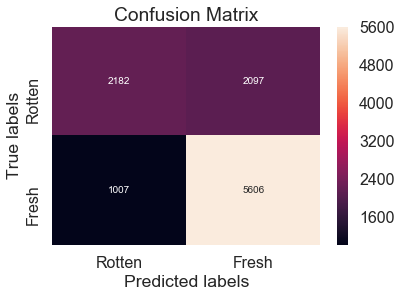

In [25]:
# still confused?  try this.
import seaborn as sns

ax= plt.subplot()
sns.heatmap(conf, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Rotten','Fresh']); ax.yaxis.set_ticklabels(['Rotten','Fresh']);

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [26]:
words = np.array(vectorizer.get_feature_names())
### We're making a new x to predict
x = np.eye(xtest.shape[1])
# predict probabilites each based on a single feature
probs = clf.predict_log_proba(x)[:, 0]
# get pointers to sorted probabilities
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             perfect 0.89
         intelligent 0.88
              moving 0.87
         performance 0.87
        entertaining 0.86
                 our 0.85
            powerful 0.85
         masterpiece 0.84
             delight 0.84
              superb 0.84
Bad words	     P(fresh | word)
      disappointment 0.28
                flat 0.28
               video 0.28
               awful 0.27
                lame 0.27
              cliche 0.27
       disappointing 0.27
                dull 0.26
         predictable 0.25
       unfortunately 0.25


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

### Exercise Set VI answer:

__The method builds a set of one word reviews and then predicts the probability of fresh/rotten given the single feature.  The probability predicted for each row is a measure of how much weight that word is given by the model (i.e. how predictive the word is).__

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [27]:
# build a dataset for the classifier
x, y = make_xy(critics, vectorizer)

# predict
prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)
# sort the probabilities
bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]
#
print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.

The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.

Mr. Rodriguez demonstrates his talents more clearly than ever -- he's visually inventive, quick-witted and a fabulous editor -- while still hampering himself with sophomoric material.

The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

Mis-predicted Fresh quotes
--------------------------
It's a one-joke movie, a funhouse ride, the cinematic equivalent of having a rubber spider

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

### Exercise Set VII answer:

* Classifier predicts fresh


* Human readers of the review immediate understand that the negation ("not") applies to the following words "remarkable", "touching", "superb", i.e. the movie is not good.  The classifier just notes the occurence of each word and takes no notice of the negation.  The individual word probabilities for fresh are overwhelmingly positive, therefore the sentence is classified as fresh.

In [28]:
prediction = clf.predict(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))
if prediction[0] == 1:
    print("Review predicted Fresh")
else:
    print("Review predicted Rotten")

Review predicted Fresh


In [29]:
my_X = vectorizer.transform(pd.Series('This movie is not remarkable, touching, or superb in any way'.split()))

In [30]:
my_predict_fresh = clf.predict_proba(my_X)[:,1]

In [31]:
# rotton probability is in column 0, fresh in column 1
my_predict_fresh

array([0.61447848, 0.61447848, 0.61447848, 0.61447848, 0.78990627,
       0.80755106, 0.57594372, 0.83791751, 0.61447848, 0.609229  ,
       0.68114673])

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [32]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [33]:
# Your turn